# Viewing PHA responses

This notebook is intended to show off the "rich display" features that allow objects like ARF, RMF, and images to be displayed graphically.

First load up the modules:

In [1]:
import numpy as np

from matplotlib import pyplot as plt

from sherpa.astro import io
from sherpa.astro import instrument
from sherpa.astro.plot import ARFPlot
from sherpa.utils.testing import get_datadir

For this notebook we shall use some of the data files from the [Sherpa test repository](https://github.com/sherpa/sherpa-test-data),
which is normally only installed when testing Sherpa.

In [2]:
def datafile(filename):
    """Access a data file from the sherpa test data"""
    return get_datadir() + "/" + filename

## The ARF

First we start with a Chandra ACIS [Auxilary Response File (ARF)](https://cxc.harvard.edu/ciao/dictionary/arf.html):

In [3]:
arf = io.read_arf(datafile("9774.arf"))
# Hide the full path name to make the plot title look nicer
arf.name = "9774.arf"

The first thing to do is print the structure, which displays the basic components:

- the energy grid over which the response is defined (the `energ_lo` and `energ_hi` fields, which are in keV
- the `specresp` field which gives the response (the effective area, in cm$^2$, for each energy bin

In [4]:
print(arf)

name     = 9774.arf
energ_lo = Float64[1078]
energ_hi = Float64[1078]
specresp = Float64[1078]
bin_lo   = None
bin_hi   = None
exposure = 75141.231099099
ethresh  = 1e-10


For notebook users we can just ask the notebook to display this object, which displays a plot of the data and some of the metadata stored with it:

In [5]:
arf

<DataARF data set instance '9774.arf'>

We can also create a Sherpa plot object directly:

In [6]:
aplot = ARFPlot()
aplot.prepare(arf)

This structure contains the data needed to create a plot (and can be created even if no Sherpa plotting backend is available):

In [7]:
print(aplot)

xlo    = [ 0.22, 0.23, 0.24,...,10.97,10.98,10.99]
xhi    = [ 0.23, 0.24, 0.25,...,10.98,10.99,11.  ]
y      = [61.9221,71.4127,81.3637,..., 0.5701, 0.5516, 0.5332]
xlabel = Energy (keV)
ylabel = cm$^2$
title  = 9774.arf
histo_prefs = {'xlog': False, 'ylog': False, 'label': None, 'xerrorbars': False, 'yerrorbars': False, 'color': None, 'linestyle': 'solid', 'linewidth': None, 'marker': 'None', 'alpha': None, 'markerfacecolor': None, 'markersize': None, 'ecolor': None, 'capsize': None}


When a plotting backend is available we can display the data, which shows a plot essentially the same as the "rich display" above, but without the metadata:

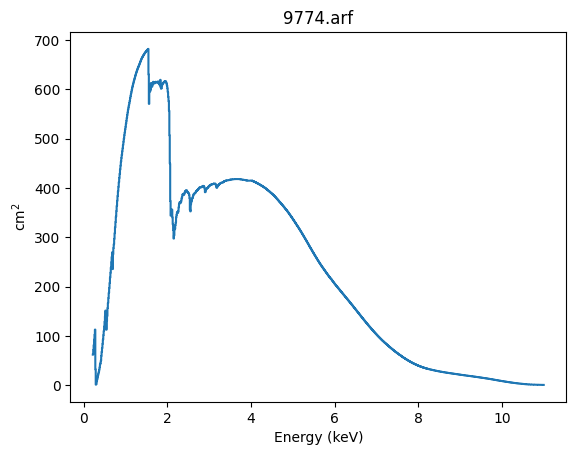

In [8]:
aplot.plot()

## The RMF

Displaying the [Redistribution Matrix File (RMF)](https://cxc.harvard.edu/ciao/dictionary/rmf.html) is harder, because it is an intrinsically two-dimensional object, as it describes how the physical propeties of the X-ray signal (in this case, the energy or wavelength) is mapped onto the detector properties (channel).

In [9]:
rmf = io.read_rmf(datafile("9774.rmf"))
rmf.name = "9774.rmf"

The matrix is stored in a compressed form, and hard to understand from the object display:

In [10]:
print(rmf)

name     = 9774.rmf
energ_lo = Float64[1078]
energ_hi = Float64[1078]
n_grp    = UInt64[1078]
f_chan   = UInt64[1481]
n_chan   = UInt64[1481]
matrix   = Float64[438482]
e_min    = Float64[1024]
e_max    = Float64[1024]
detchans = 1024
offset   = 1
ethresh  = 1e-10


The "rich display" picks 5 energies, spaced logarithmically across the energy response of the RMF,
and shows the behavior of monochromatic emission at this energy, along with some of the metadata
related to the file.

We can see why fitting X-ray data can be hard, since 3 keV photons do peak at 3 keV but can also
be observed down to 1 keV.

In [11]:
rmf

<DataRMF data set instance '9774.rmf'>

Note that there is no equivalent to the `ARFPlot` class for RMF.

New in Sherpa 4.16.0 is the ability to convert a RMF into a 2D image, which shows the relationshiop
between channel (X axis) and energy (Y axis). It is essentially the same as the CIAO tool
[rmfimg](https://cxc.harvard.edu/ciao/ahelp/rmfimg.html).

We can convert a RMF into a `DataIMG` structure:

In [12]:
image_rmf = instrument.rmf_to_image(rmf)

As always, let's see what is stored in it. Although the data in in 2D, the `DataIMG` structrure flattens it out into 1D arrays:

In [13]:
print(image_rmf)

name      = 9774.rmf
x0        = Int64[1103872]
x1        = Int64[1103872]
y         = Float64[1103872]
shape     = (1078, 1024)
staterror = None
syserror  = None
sky       = None
eqpos     = None
coord     = logical


However, we can use the rich display to show this data. Note that this uses a linear scale for the data, and so all we see is the
"main" response, which shows the main peaks we saw in the line plot above.

Although not labelled, the X axis is in channel space. For the Chandra [ACIS detector](https://cxc.harvard.edu/ciao/dictionary/acis.html)
this has 1024 channels. The Y axis is energy range, which depends on how the RMF was built (it maps to the `ENERG_LO` and `ENERG_HI`
columns from the `MATRIX` block of the RMF, in this case accessible as `rmf.energ_lo` and `rmf.energ_hi`).

In [14]:
image_rmf

<DataIMG data set instance '9774.rmf'>

We can access the matrix directly with `rmf_to_matrix` rather than `rmf_to_inage` (we could reconstruct the data from the
`image_rmf` structure, but the following is a lot more informative):

In [15]:
matinfo = instrument.rmf_to_matrix(rmf)

This object does not have a "nice" string representation, but it contains three fields:

- `matrix`
- `channels`
- `energies`

The matrix is the 2D data shown above:

In [16]:
print(matinfo.matrix.shape)

(1078, 1024)


In [17]:
matinfo.matrix.min(), matinfo.matrix[matinfo.matrix>0].min(), matinfo.matrix.max()

(0.0, 8.81322481660618e-09, 0.13163885474205017)

This can be displayed with a log scale, to show off some of the secondary features we saw in the monochromatic energy response above. The horizontal lines are added to indicate rows which we shall investigate later.

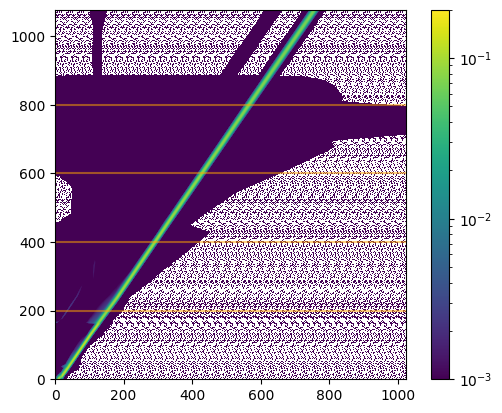

In [18]:
from matplotlib import colors

plt.imshow(matinfo.matrix, origin='lower', norm=colors.LogNorm(vmin=1e-3, vmax=0.2))
plt.colorbar()

for pos in [200, 400, 600, 800]:
    plt.axhline(pos, alpha=0.5, c='orange')

We can use this data to try and reconstruct the monochromatic response plot from above. We can pick a row from the matrix,
which will be the response for a photon at a fixed energy (well, a photon in the finite energy range given by the
corresponding element from the `energ_lo` and `energ_hi` fields).

Selecting values along the Y axis selects different ranges (and let's us explore some of the features seen above). One difference
to the rich display above is that this plot uses channel number for the X axis rather than converting this to an 
"approximate" energy (as done above), by using the `E_MIN` and `E_MAX` fields from the `EBOUNDS` block of the RMF
(available as `rmf.e_min` and `rmf.e_max`).

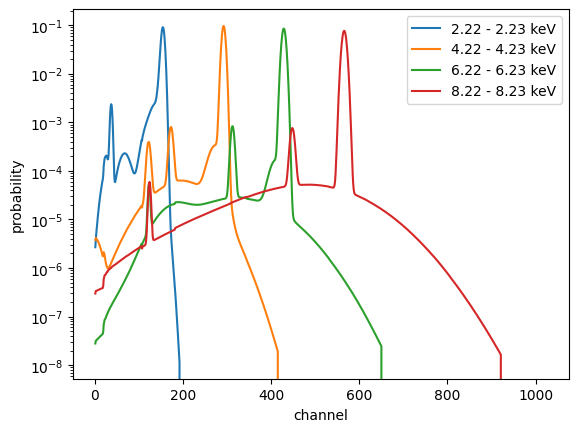

In [19]:
for idx in [200, 400, 600, 800]:
    # We could use matinfo.energies, but as we have the RMF object we use that instead.
    elo = rmf.energ_lo[idx]
    ehi = rmf.energ_hi[idx]
    plt.plot(np.arange(1, 1025), matinfo.matrix[idx, :], label=f"{elo:.2f} - {ehi:.2f} keV")
    
plt.yscale('log')
plt.xlabel("channel")
plt.ylabel("probability")
plt.legend();

## Looking at a different detector

The Sherpa test data directory contains a response file for the [ROSAT PSPC-C](https://heasarc.gsfc.nasa.gov/docs/rosat/pspc.html) instrument, which operated
in the 1990s, and used a different detector to the CCD detector used in ACIS. We can see how different by viewing the response using the techniques from above: 

In [20]:
rsp_pspcc = io.read_rmf(datafile("pspcc_gain1_256.rsp"))
rsp_pspcc.name = "pspcc_gain1_256.rsp"
rsp_pspcc

<DataRosatRMF data set instance 'pspcc_gain1_256.rsp'>

In [21]:
instrument.rmf_to_image(rsp_pspcc)

<DataIMG data set instance 'pspcc_gain1_256.rsp'>

Note that the ROSAT RMF includes the effective area (i.e. ARF) terms, which is why the matrix values are greater than 1 and some of the vertical structureof the plot. We can see the lower resolving power of the instrument by the fact the line above is not as sharp as the CCD version above. If we used a Chandra grating RMF the line would be much narrower (but harder to see as there's more pixels).

## Using the responses

How do we apply the response to a model?

In [22]:
from sherpa.astro.instrument import ARF1D, RMF1D, RSPModelNoPHA
from sherpa.models.basic import Delta1D, NormGauss1D

There are several ways of applying the response. Here we chose to use the "wrapper" models `ARF1D` and `RMF1D` to convert the `DataARF` and `DataRMF`
structures into "convolution-style" models[$\dagger$].

---

[$\dagger$] technically only the RMF needs to be handled as a convolution model, but for historical reasons the ARF is handled the same way.

In [23]:
aconv = ARF1D(arf)
rconv = RMF1D(rmf)

Let's create a model consisting of a delta function, at 2 keV, together with a gaussian centered at 6 keV and with a FWHM of 1 keV:

In [24]:
dmodel = Delta1D("delta")
gmodel = NormGauss1D("gauss")

dmodel.pos = 2
gmodel.pos = 6
gmodel.fwhm = 1

# Adjust the gaussian amplitude so that it is more visible.
gmodel.ampl = 100

model_base = dmodel + gmodel
model_base

<BinaryOpModel model instance '(delta + gauss)'>

Let's just check that both components have the integrate flag set to `True` (the composite model does not pass through the integrate
setting of its components in Sherpa 4.16.0):

In [25]:
dmodel.integrate, gmodel.integrate

(True, True)

We can evaluate this to get "the truth" (for XSPEC additive models the per-bin value would have units of photon / cm$^2$ / s, but for the Sherpa models we can give the `ampl` parameter (for these two models) whatever units we want, so let's also assume the same units as XSPEC.

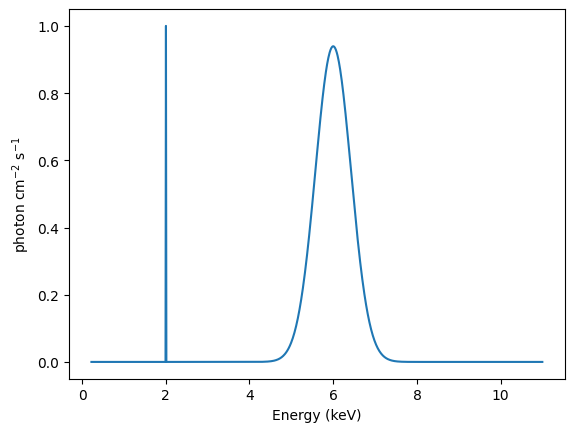

In [26]:
y_base = model_base(rmf.energ_lo, rmf.energ_hi)

emid = (rmf.energ_lo + rmf.energ_hi) / 2
plt.plot(emid, y_base)
plt.xlabel("Energy (keV)")
plt.ylabel("photon cm$^{-2}$ s$^{-1}$");

The ARF is incluced by "convolving" the base model by the ARF model. Note that, as the ARF contains an exposure time, the model automatically includes this, which means that the output
is now not a rate. In fact, because the ARF has units of cm$^2$, the model evaluation will calculate the number of photons per bin.

In [27]:
model_arf = aconv(model_base)
model_arf

<ARFModelNoPHA model instance 'apply_arf((75141.231099099 * (delta + gauss)))'>

Each bin is multiplied by the ARF, so - since the ARF is not flat - the relative signal will change (the ARF is overplotted to show the difference):

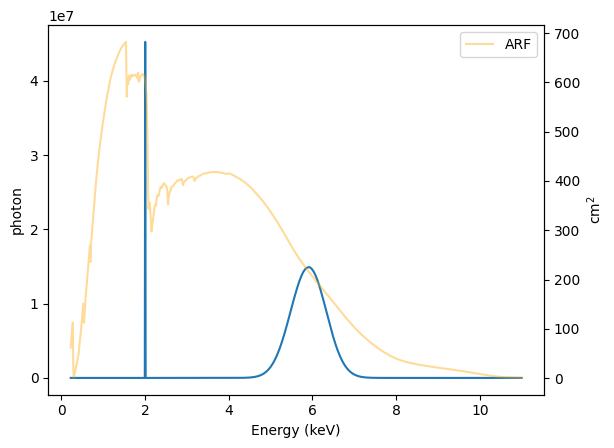

In [28]:
y_arf = model_arf(rmf.energ_lo, rmf.energ_hi)

plt.plot(emid, y_arf)
plt.xlabel("Energy (keV)")
plt.ylabel("photon")

ax2 = plt.twinx();
emid2 = (arf.energ_lo + arf.energ_hi) / 2
ax2.plot(emid, arf.specresp, alpha=0.4, c="orange", label="ARF")
ax2.set_ylabel("cm$^2$")
plt.legend();

We can repeat this for the RMF, noting that the output - because the ARF is not included - will have the unusual units of count / cm$^2$ / s:

In [29]:
model_rmf = rconv(model_base)
model_rmf

<RMFModelNoPHA model instance 'apply_rmf((delta + gauss))'>

An interesting part of this is that the RMF converts between physical units (energy or wavelength), which is used to evaluate the "wrapped" model (in this
case `model_base`), and returns values in channel space. This means that we no-longer supply the convolved model with energies, but with channels[$\ddagger$].

The obvious differences to above are that the relative intensity of the delta function and gaussian has drastically changed, and the blurring of the created by
the RMF is visible (well, it is once you change to a logarithmic scale for the Y axis).

---

[$\ddagger$] Thanks to an oddity of the RMF interface, we just need to send a sequence to the convolved model to evaluate it. However, we shall do it "properly" here.

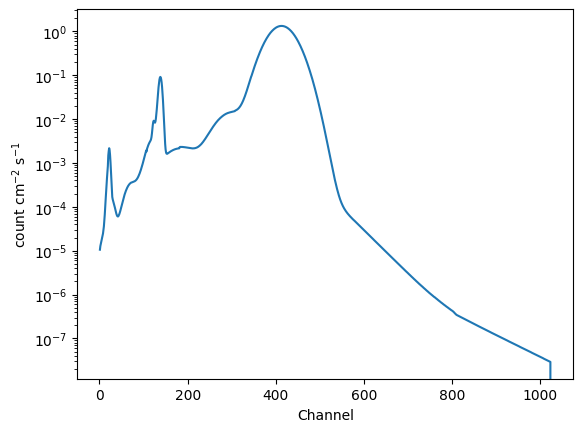

In [30]:
channels = np.arange(1, 1025, dtype=np.int16)
y_rmf = model_rmf(channels)

plt.plot(channels, y_rmf)
plt.xlabel("Channel")
plt.ylabel("count cm$^{-2}$ s$^{-1}$")
plt.yscale("log");

We can use the "approximate" energies from the RMF to get a plot more similar to the `plot_data` command (UI) or `DataPHAPlot` (direct use of the plotting classes):

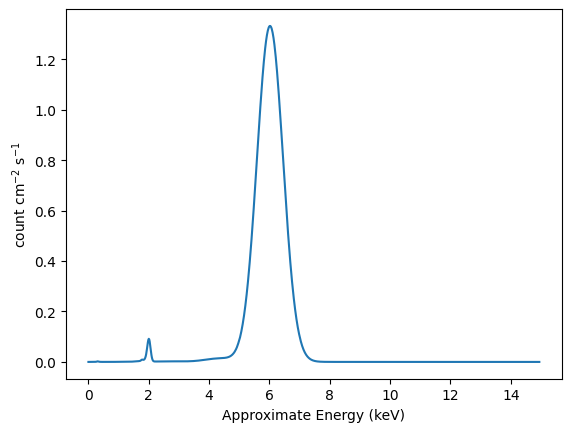

In [31]:
emid_approx = (rmf.e_min + rmf.e_max) / 2

plt.plot(emid_approx, y_rmf)
plt.xlabel("Approximate Energy (keV)")
plt.ylabel("count cm$^{-2}$ s$^{-1}$");

We could combine both with an expression like

    rconv(aconv(model_base))

but we shall also use the `RSPModelNoPHA` class, which takes ARF, RMF, **and** the model as arguments:

In [32]:
model_both = RSPModelNoPHA(arf, rmf, model_base)
model_check = rconv(aconv(model_base))

In [33]:
model_both

<RSPModelNoPHA model instance 'apply_rmf(apply_arf((delta + gauss)))'>

In [34]:
model_check

<RMFModelNoPHA model instance 'apply_rmf(apply_arf((75141.231099099 * (delta + gauss))))'>

The model display for `model_both` is *interesting*, since it does **not** include the exposure time![$\dagger\dagger$]

This means that the `y_both` output is a rate (count / s), whereas `y_check` has units of count.

---

[$\dagger\dagger$] Please check the [Sherpa issues page](https://github.com/sherpa/sherpa/issues/1895) as this behaviour may change.

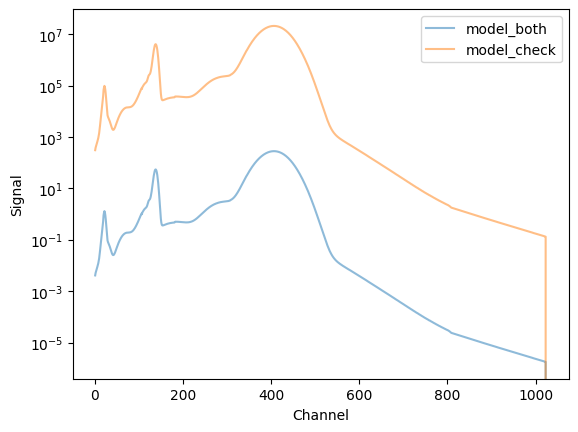

In [35]:
y_both = model_both(channels)
y_check = model_check(channels)

plt.plot(channels, y_both, label="model_both", alpha=0.5)
plt.plot(channels, y_check, label="model_check", alpha=0.5)

plt.xlabel("Channel")
plt.ylabel("Signal")
plt.legend()
plt.yscale("log");

So, here we have evaluated a model and passed it through both the ARF and RMF.

## Checking the logic

We can check the earlier code, where I used `matinfo.matrix[row, :]` to display the monochromatic model. We can take a delta function, set it to
an known energy, and then convolve it with the RMF. The result of evaluating this model should match the direct access.

To do this we need to know how to map between the `row` value and the energies, which comes from the `rmf.energ_lo` and `rmf.energ_hi` arrays:

In [36]:
row = 500
elo = rmf.energ_lo[row]
ehi = rmf.energ_hi[row]

eval = (elo + ehi) / 2
elo, ehi, eval

(5.21999979019165, 5.230000019073486, 5.224999904632568)

Evaluating the model produces the same result as just selecting a row from the matrix (although this is only true for a delta function model).

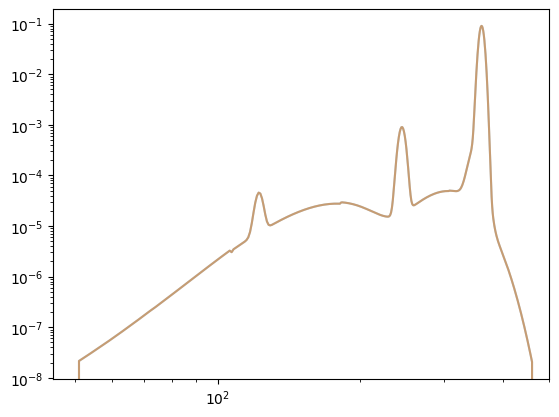

In [37]:
check = Delta1D()
check.pos = eval

check_rmf = rconv(check)

y1 = check_rmf(channels)
y2 = matinfo.matrix[row, :]

plt.plot(channels, y1, alpha=0.5)
plt.plot(channels, y2, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlim(45, 500);

A more mathematical, but less visually impressive, check is:

In [38]:
(y1 == y2).all()

True